In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
METHOD_NAME = "method"
OUTCOME_FEATURE = "PEHE"
STD_FEATURE = "sd"


plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Palatino"],
    }
)

plt.rcParams.update({"font.size": 25})
plt.rc("figure", titlesize=17)


# workaround
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np


class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = "squareroot"

    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(0.0, vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a):
            return np.array(a) ** 0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a) ** 2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()


mscale.register_scale(SquareRootScale)


def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = "{:g}".format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str


# Set up the formatter.
from matplotlib.ticker import FuncFormatter

rem_leadingzeroformatter = FuncFormatter(my_formatter)


def plot_grouped_line_with_errorbars_2(
    df_plot: pd.DataFrame,
    input_feature: str,
    outcome_feature: str,
    std_feature="sd",
    ci=1,
    ylab="",
    grouping_feature=METHOD_NAME,
    ylim: list = None,
    title: str = None,
    xticks=[0, 0.2],
    yticks=None,
    show: bool = False,
    plot_size=[2, 3],
    plot_sd: bool = False,
    scatter: bool = False,
    ax=None,
    return_ax=False,
    no_legend: bool = True,
    no_y: bool = False,
    xlab=r"$\rho$",
    dashes=None,
    legend_title=None,
    decimals="rem",
    title_size=17,
    lab_size=15.5,
    legend_size=12,
    cust_labeldist=None,
    ticksize=16,
    colors=None,
    labelpos_y=None,
    labelpos_x=None,
    no_xticks=False,
    no_yticks=False,
    xlim=None,
    xsqrtscl=False,
    xdecimals="rem",
    xlabeldist=-0.1,
    markers=None,
):
    df_plot = df_plot.copy()
    if ax is None:
        ax = plt.gca()

    groups = df_plot[grouping_feature].unique()
    n_groups = df_plot[grouping_feature].nunique()
    if colors is None:
        colors = sns.color_palette("colorblind", n_colors=n_groups)

    if scatter:
        sns.scatterplot(
            data=df_plot,
            x=input_feature,
            y=outcome_feature,
            hue=df_plot[grouping_feature].tolist(),
            palette=colors,
            ax=ax,
        )
    else:
        if dashes is not None:
            if markers is None:
                points = ["o", "*", "v", "^"]
                mult = n_groups // len(points) + (n_groups % len(points) > 0)
                markers = {key: value for (key, value) in zip(groups, points * mult)}
            sns.lineplot(
                data=df_plot,
                x=input_feature,
                style=grouping_feature,
                y=outcome_feature,
                hue=grouping_feature,
                palette=colors,
                markers=markers,
                dashes=dashes,
                ax=ax,
            )
        else:
            sns.lineplot(
                data=df_plot,
                x=input_feature,
                style=grouping_feature,
                y=outcome_feature,
                hue=grouping_feature,
                palette=colors,
                ax=ax,
                markers=True,
            )

    if plot_sd:
        # add error bars
        df_plot["upper"] = df_plot[outcome_feature] + ci * df_plot[std_feature]
        df_plot["lower"] = df_plot[outcome_feature] - ci * df_plot[std_feature]
        # loop through the groups to create error bars
        groups = list(df_plot[grouping_feature].unique())
        for n_group, group in enumerate(groups):
            if df_plot.loc[df_plot[grouping_feature] == group, :][std_feature].isnull().any():
                continue
            if isinstance(colors, dict):
                err_color = colors[group]
            else:
                err_color = colors[n_group]

            # for val in df_plot.loc[df_plot[grouping_feature] == group, :][outcome_feature].unique():
            df_subset = (
                df_plot.loc[(df_plot[grouping_feature] == group), :].copy().sort_values(by=input_feature)
            )  # (df_plot[outcome_feature]
            # == val), :].copy()

            ax.fill_between(
                df_subset[input_feature],
                df_subset["lower"],
                df_subset["upper"],
                interpolate=False,
                color=err_color,
                alpha=0.2,
            )
    # set ylim
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    if decimals == 0:
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))
        ax.yaxis.set_label_coords(-0.1 if cust_labeldist is None else cust_labeldist, 0.5)
    elif decimals == 1:
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
        ax.yaxis.set_label_coords(-0.2 if cust_labeldist is None else cust_labeldist, 0.5)
    elif decimals == 2:
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.2f"))
    elif decimals == 3:
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%.3f"))
    elif decimals == "rem":
        ax.yaxis.set_major_formatter(rem_leadingzeroformatter)

    if xdecimals == 0:
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.0f"))
    elif xdecimals == 1:
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%.1f"))
    elif xdecimals == "rem":
        ax.xaxis.set_major_formatter(rem_leadingzeroformatter)

    if xlabeldist is not None:
        ax.xaxis.set_label_coords(1, xlabeldist)

    if xsqrtscl:
        ax.set_xscale("squareroot")
    if no_y:
        plt.ylabel("", fontsize=18)
    else:
        ax.set_ylabel(ylab, fontsize=lab_size)

    if xlab is not None:
        ax.set_xlabel(xlab, fontsize=lab_size)
    else:
        plt.xlabel("")

    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    if no_yticks or no_y or (ylab == ""):
        ax.set_yticklabels("")
    if no_xticks:
        ax.set_xticklabels("")

    if ticksize is not None:
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)

    if title is not None:
        plt.title(title, fontsize=title_size)

    if labelpos_y is not None:
        ax.yaxis.set_label_coords(*labelpos_y)
    if labelpos_x is not None:
        ax.xaxis.set_label_coords(*labelpos_x)

    # ax.set_ylabel(ylab)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], bbox_to_anchor=(1, 1), loc="upper left")
    plt.legend(fontsize=legend_size, title=legend_title)
    if no_legend:
        ax.get_legend().remove()

    # plt.tight_layout()

    if return_ax:
        return ax

In [4]:
COLORS_LEARNER = {
    "oracle": "#999999",
    "r": "#b2182b",
    "dr": "#ef8a62",
    "s_ext": "#abd9e9",
    "s": "#67a9cf",
    "t": "#2166ac",
}
# {'oracle': '#e7d4e8', 'r': '#762a83', 'dr': '#af8dc3', 's': '#d9f0d3', 's_ext': '#7fbf7b', 't': '#1b7837'}
#
COLORS_CRIT_BASE = {
    "oracle": "#999999",
    "factual": "black",
    "r": "#762a83",  #'#c51b7d',
    "dr": "#f1b6da",
    "w_factual": "#a6dba0",
    # 'dr': "#b2abd2", 'r':'#542788',purple
    "r_plug": "#b2182b",
    "dr_plug": "#ef8a62",
    "s_ext": "#abd9e9",
    "s": "#67a9cf",
    "t": "#2166ac",
}
COLS_METHS = {}
for key, val in COLORS_CRIT_BASE.items():
    if (not key == "oracle") and (not key == "factual") and ((not key == "w_factual")):
        COLS_METHS[key + "-lr"] = val
        COLS_METHS[key + "-xgb_cv"] = val

COLORS_CRIT = {**COLORS_CRIT_BASE, **COLS_METHS}

In [5]:
def colors_by_learner(short=False):
    col_map = {}
    for key, val in COLORS_LEARNER.items():
        learner_name = PRETTY_LEARNERS_LONG[key] if not short else PRETTY_LEARNERS_SHORT[key]
        col_map[learner_name] = val
    return col_map


def colors_by_crit(short=False):
    col_map = {}
    for key, val in COLORS_CRIT.items():
        learner_name = PRETTY_CRITS_LONG_S[key] if not short else PRETTY_CRITS_SHORT[key]
        col_map[learner_name] = val
    return col_map

In [6]:
DASHES_LEARNERS = {"t": "", "s_ext": "", "r": "", "dr": "", "s": "", "oracle": (3, 1)}
DASHES_BASE = {
    "factual": (5, 1),
    "oracle": (3, 1),  # (0, (1, 10)),
    "t": "",
    "s_ext": "",
    "r_plug": "",
    "dr_plug": "",
    "r": (1, 1),
    "dr": (1, 1),
}  # (0,(5, 5)), 'dr':  (0,(5, 5))}
# {'factual': 'dashdot', 'oracle':'dotted', 't': 'solid', 's_ext': 'solid', 'r_plug': 'solid', 'r': 'dashed', 'dr': 'dashed'}
DASHES_METHS = {}
for key, val in DASHES_BASE.items():
    if (not key == "oracle") and (not key == "factual"):
        DASHES_METHS[key + "-lr"] = val
        DASHES_METHS[key + "-xgb_cv"] = val
DASHES_CRITS = {**DASHES_BASE, **DASHES_METHS}


def dashes_by_crit(short=True):
    col_map = {}
    for key, val in DASHES_CRITS.items():
        learner_name = PRETTY_CRITS_LONG_S[key] if not short else PRETTY_CRITS_SHORT[key]
        col_map[learner_name] = val
    return col_map


def dashes_by_learner(short=False):
    col_map = {}
    for key, val in DASHES_LEARNERS.items():
        learner_name = PRETTY_LEARNERS_LONG[key] if not short else PRETTY_LEARNERS_SHORT[key]
        col_map[learner_name] = val
    return col_map

In [7]:
MARKERS_LEARNERS = {"r": "D", "dr": "v", "t": "o", "s": "o", "s_ext": "o", "oracle": "*"}
MARKERS_BASE = {
    "r": "D",
    "r_plug": "D",
    "dr": "v",
    "dr_plug": "v",
    "t": "o",
    "s": "o",
    "s_ext": "o",
    "factual": "P",
    "oracle": "*",
}
MARKERS_METHS = {}
for key, val in MARKERS_BASE.items():
    if (not key == "oracle") and (not key == "factual"):
        MARKERS_METHS[key + "-lr"] = val
        MARKERS_METHS[key + "-xgb_cv"] = val
MARKERS_CRITS = {**MARKERS_BASE, **MARKERS_METHS}


def markers_by_crit(short=True):
    col_map = {}
    for key, val in MARKERS_CRITS.items():
        learner_name = PRETTY_CRITS_LONG_S[key] if not short else PRETTY_CRITS_SHORT[key]
        col_map[learner_name] = val
    return col_map


def markers_by_learner(short=False):
    col_map = {}
    for key, val in MARKERS_LEARNERS.items():
        learner_name = PRETTY_LEARNERS_LONG[key] if not short else PRETTY_LEARNERS_SHORT[key]
        col_map[learner_name] = val
    return col_map

In [8]:
METHOD_NAME = "method"

PRETTY_LEARNERS_SHORT = {
    "r": "R",
    "dr": "DR",
    "s": "S",
    "s_ext": "ES",
    "t": "T",
    "r-lr": "R (LR)",
    "dr-lr": "DR (LR)",
    "s-lr": "S (LR)",
    "s_ext-lr": "ES (LR)",
    "t-lr": "T (LR)",
    "r-xgb_cv": "R (GB)",
    "dr-xgb_cv": "DR (GB)",
    "s-xgb_cv": "S (GB)",
    "s_ext-xgb_cv": "ES (GB)",
    "t-xgb_cv": "T (GB)",
    "oracle": "Oracle reg.",
    "oracle-lr": "Oracle reg. (LR)",
    "oracle-xgb_cv": "Oracle reg. (GB)",
}

PRETTY_LEARNERS_LONG = {
    "r": "R-learner",
    "dr": "DR-learner",
    "s": "S-learner",
    "s_ext": "ES-learner",
    "t": "T-learner",
    "r-lr": "R-learner (LR)",
    "dr-lr": "DR-learner (LR)",
    "s-lr": "S-learner (LR)",
    "s_ext-lr": "ES-learner (LR)",
    "t-lr": "T-learner (LR)",
    "r-xgb_cv": "R-learner (GB)",
    "dr-xgb_cv": "DR-learner (GB)",
    "s-xgb_cv": "S-learner (GB)",
    "s_ext-xgb_cv": "ES-learner (GB)",
    "t-xgb_cv": "T-learner (GB)",
    "oracle": "Oracle reg.",
    "oracle-lr": "Oracle reg. (LR)",
    "oracle-xgb_cv": "Oracle reg. (GB)",
}

PRETTY_CRITS_LONG = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": "R (pseudo, LR)",
    "dr-lr": "DR (pseudo, LR)",
    "s-lr": "S (plug, LR)",
    "s_ext-lr": "ES (plug, LR)",
    "t-lr": "T (plug, LR)",
    "r-xgb_cv": "R (pseudo, GB)",
    "dr-xgb_cv": "DR (pseudo, GB)",
    "s-xgb_cv": "S (plug, GB)",
    "s_ext-xgb_cv": "ES (plug, GB)",
    "r_plug-xgb_cv": "R (plug, GB)",
    "dr_plug-xgb_cv": "DR (plug, GB)",
    "t-xgb_cv": "T (plug, GB)",
    "r_plug": "R (plug)",
    "dr_plug": "DR (plug)",
    "r_plug-lr": "R (plug, LR)",
    "dr_plug-lr": "DR (plug, LR)",
    "factual": "Factual",
    "oracle": "Oracle Selector",
    "w_factual": "weight. Fact.",
    "pw": "PW (pseudo)",
}

PRETTY_CRITS_LONG_S = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": "R-LR (pseu.)",
    "dr-lr": "DR (pseudo, LR)",
    "s-lr": "S (plug, LR)",
    "s_ext-lr": "ES (plug, LR)",
    "t-lr": "T (plug, LR)",
    "r-xgb_cv": "R-GB (pseu.)",
    "dr-xgb_cv": "DR (pseudo, GB)",
    "s-xgb_cv": "S (plug, GB)",
    "s_ext-xgb_cv": "ES (plug, GB)",
    "r_plug-xgb_cv": "R (plug, GB)",
    "dr_plug-xgb_cv": "DR (plug, GB)",
    "t-xgb_cv": "T (plug, GB)",
    "r_plug": "R (plug)",
    "dr_plug": "DR (plug)",
    "r_plug-lr": "R (plug, LR)",
    "dr_plug-lr": "DR (plug, LR)",
    "factual": "Factual",
    "oracle": "Oracle Selector",
    "w_factual": "weighted Factual",
    "pw": "PW (pseudo)",
}
PRETTY_CRITS_SHORT = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "if-lr": "Influence function",
    "if-xgb_cv": "IF",
    "match": "Matching",
    "r-lr": "R (pseudo)",
    "dr-lr": "DR (pseudo)",
    "s-lr": "S (plug)",
    "s_ext-lr": "ES (plug)",
    "t-lr": "T (plug)",
    "ra-lr": "RA (pseudo)",
    "ra-xgb_cv": "RA (pseudo)",
    "r-xgb_cv": "R (pseudo)",
    "dr-xgb_cv": "DR (pseudo)",
    "s-xgb_cv": "S (plug)",
    "pw": "PW (pseudo)",
    "s_ext-xgb_cv": "ES (plug)",
    "r_plug-xgb_cv": "R (plug)",
    "dr_plug-xgb_cv": "DR (plug)",
    "r_plug": "R (plug)",
    "dr_plug": "DR (plug)",
    "r_plug-lr": "R (plug)",
    "dr_plug-lr": "DR (plug)",
    "factual": "Factual",
    "oracle": "Oracle Selector",
    "t-xgb_cv": "T (plug)",
    "w_factual": "weight. Fact.",
}


def make_plot_frame(
    results_mean,
    results_sd,
    crit_names=["oracle", "factual", "s", "s_ext", "t", "dr", "r", "dr_prefit", "r_prefit"],
    crit_model_names=["lr", "xgb", "rf", "xgb_cv"],
    dim_name="xi",
    subset_names=None,
    res_type="rmse_cate",
    res_type_methods="test_pehe",
    abbr=False,
    subset_trans=None,
    subset_inter_t=None,
    subset_xi=None,
    subset_n=None,
    subset_prop=None,
    subset_scl=None,
    subset_splin=None,
    subset_name=None,
    subset_sp1=None,
    subset_cols=None,
    subset_setting=None,
    subset_num=None,
    subset_rel_prop=None,
    plot_methods=False,
    plot_crits=True,
    plot_sd=True,
    subset_misprop=None,
    input_by_method=False,
    rem_method_names=True,
):
    if subset_misprop is not None:
        results_mean = results_mean.loc[results_mean["misprop"] == subset_misprop, :]
        results_sd = results_sd.loc[results_sd["misprop"] == subset_misprop, :]

    if subset_xi is not None:
        results_mean = results_mean.loc[results_mean["xi"] == subset_xi, :]
        results_sd = results_sd.loc[results_sd["xi"] == subset_xi, :]

    if subset_n is not None:
        results_mean = results_mean.loc[results_mean["n_train"] == subset_n, :]
        results_sd = results_sd.loc[results_sd["n_train"] == subset_n, :]

    if subset_prop is not None:
        results_mean = results_mean.loc[results_mean["prop_type"] == subset_prop, :]
        results_sd = results_sd.loc[results_sd["prop_type"] == subset_prop, :]

    if subset_sp1 is not None:
        results_mean = results_mean.loc[
            results_mean["sp_1"] == subset_sp1
            if not type(subset_sp1) is list
            else results_mean["sp_1"].isin(subset_sp1),
            :,
        ]
        results_sd = results_sd.loc[
            results_sd["sp_1"] == subset_sp1 if not type(subset_sp1) is list else results_sd["sp_1"].isin(subset_sp1), :
        ]

    if subset_cols is not None:
        results_mean = results_mean.loc[results_mean["subset_cols"] == subset_cols, :]
        results_sd = results_sd.loc[results_sd["subset_cols"] == subset_cols, :]

    if subset_setting is not None:
        # IHDP only
        results_mean = results_mean.loc[results_mean["setting"] == subset_setting, :]
        results_sd = results_sd.loc[results_sd["setting"] == subset_setting, :]

    if subset_num is not None:
        # Acic original only
        results_mean = results_mean.loc[results_mean["simu_num"] == subset_num, :]
        results_sd = results_sd.loc[results_sd["simu_num"] == subset_num, :]

    if subset_trans is not None:
        results_mean = results_mean.loc[results_mean["trans_cov"] == subset_trans, :]
        results_sd = results_sd.loc[results_sd["trans_cov"] == subset_trans, :]

    if subset_scl is not None:
        results_mean = results_mean.loc[results_mean["nonlin_scale"] == subset_scl, :]
        results_sd = results_sd.loc[results_sd["nonlin_scale"] == subset_scl, :]

    if subset_inter_t is not None:
        results_mean = results_mean.loc[results_mean["inter_t"] == subset_inter_t, :]
        results_sd = results_sd.loc[results_sd["inter_t"] == subset_inter_t, :]

    if subset_rel_prop is not None:
        results_mean = results_mean.loc[results_mean["rel_prop"] == subset_rel_prop, :]
        results_sd = results_sd.loc[results_sd["rel_prop"] == subset_rel_prop, :]

    if subset_splin is not None:
        results_mean = results_mean.loc[results_mean["sp_lin"] == subset_splin, :]
        results_sd = results_sd.loc[results_sd["sp_lin"] == subset_splin, :]

    if subset_name is not None:
        results_mean = results_mean.loc[results_mean["name"] == subset_name, :]
        results_sd = results_sd.loc[results_sd["name"] == subset_name, :]

    if plot_crits and crit_names is not None:
        # make composite names
        method_names = []
        for crit in crit_names:
            if crit in ["oracle", "po_oracle", "factual", "w_factual", "w_factual_prefit", "match", "pw"]:
                method_names.append(crit)
            else:
                for mod in crit_model_names:
                    method_names.append(crit + "-" + mod)

        # get clean names
        crits = {x: (PRETTY_CRITS_SHORT[x] if abbr else PRETTY_CRITS_LONG_S[x]) for x in method_names}
    else:
        crits = {}

    plot_frame = pd.DataFrame(columns=[dim_name, METHOD_NAME, "metric", "sd"])

    for key, val in crits.items():
        try:
            # allow for names to not be present
            new_frame = pd.DataFrame(
                data={
                    dim_name: (results_mean[dim_name] if not input_by_method else results_mean[dim_name + "_" + key]),
                    METHOD_NAME: val,
                    "metric": (results_mean[res_type + "_" + key]),
                    "sd": ((results_sd[res_type + "_" + key])) if plot_sd else 0,
                }
            )

            new_frame = new_frame.dropna()

            plot_frame = pd.concat([plot_frame, new_frame])
        except KeyError:
            continue

    if plot_methods:
        # get underlying scores of models
        method_names = [
            x
            for x in results_mean.columns
            if ((res_type_methods in x) and ("rel" not in x if ("rel" not in res_type_methods) else True))
        ]
        methods = {x: x.replace(res_type_methods + "_", "") for x in method_names}
        if subset_names is not None:
            methods_new = {}
            for name in subset_names:
                methods_new.update({key: val for key, val in methods.items() if name + "-" in val})
            methods = methods_new
        if rem_method_names:
            methods = {key: val.replace("-xgb_cv", "").replace("-lr", "") for key, val in methods.items()}
        methods = {
            key: (PRETTY_LEARNERS_SHORT[val] if abbr else PRETTY_LEARNERS_LONG[val]) for key, val in methods.items()
        }

        for key, val in methods.items():
            new_frame = pd.DataFrame(
                data={
                    dim_name: results_mean[dim_name]
                    if not input_by_method
                    else results_mean[dim_name_methods + "_" + key],
                    METHOD_NAME: val,
                    "metric": results_mean[key],
                    "sd": results_sd[key] if plot_sd else 0,
                }
            )

            new_frame = new_frame.dropna()
            plot_frame = pd.concat([plot_frame, new_frame])

    convert_dict = {dim_name: float, "metric": float, "sd": float}
    return plot_frame.astype(convert_dict)

In [9]:
CRIT_METRICS = ["rmse_cate_", "rmse_mu0_", "rmse_mu1_", "rmse_factual_", "rmse_po_"]
MODEL_METRICS = ["test_pehe_", "test_factual_", "test_pos_"]
TOL = 0.0001


def agg_data(
    res,
    subset_setting="acic",
    baseline_crit="factual",
    baseline_model=None,
    rel_diff=True,
    pre_trans=False,
    drop_outliers=False,
    verbose=False,
    extra_agg_dim=None,
):
    res = res.loc[res["setting_name"].str.contains(subset_setting), :]
    agg_dim = ["setting_name"]  # if subset_setting == 'acic' else ['setting_name', 'seed']
    if extra_agg_dim is not None:
        agg_dim = agg_dim + extra_agg_dim

    if any(res.groupby(agg_dim).count()["seed"] > 20) and verbose:
        print(
            "More that 20 sims for settings {}".format(
                res.groupby(agg_dim)
                .count()
                .reset_index()
                .loc[res.groupby(agg_dim).count().reset_index()["seed"] > 20, "setting_name"]
            )
        )
        print(
            res.groupby(agg_dim)
            .count()
            .reset_index()
            .loc[res.groupby(agg_dim).count().reset_index()["seed"] > 20, "seed"]
        )
    if any(res.groupby(agg_dim).count()["seed"] < 20) and verbose:
        print(
            "Less than 20 sims for settings {}".format(
                res.groupby(agg_dim)
                .count()
                .reset_index()
                .loc[res.groupby(agg_dim).count().reset_index()["seed"] < 20, "setting_name"]
            )
        )
        print(
            res.groupby(agg_dim)
            .count()
            .reset_index()
            .loc[res.groupby(agg_dim).count().reset_index()["seed"] < 20, "seed"]
        )
        return res.groupby(agg_dim).count().reset_index()
    if baseline_crit is not None:
        # compute relative performance
        for metric in CRIT_METRICS:
            metric_cols = [x for x in res.columns if metric in x]

            for col in metric_cols:
                res["rel_" + col] = (
                    (res[col] - res[metric + baseline_crit])
                    if rel_diff
                    else (res[col] / (res[metric + baseline_crit] + TOL))
                )

    if baseline_model is not None:
        # compute relative performance
        for metric in MODEL_METRICS:
            metric_cols = [x for x in res.columns if metric in x]
            for col in metric_cols:
                res["rel_" + col] = (
                    (res[col] - res[metric + baseline_model])
                    if rel_diff
                    else (res[col] / (res[metric + baseline_model] + TOL))
                )
    if drop_outliers:
        # drop rows where something went wrong
        zscore = lambda x: (x - x.mean()) / x.std()
        res_out = res.copy().reset_index()
        normal_rows = (
            res_out.groupby("setting_name", as_index=False)[
                [x for x in res_out.columns if ("test_pehe_" in x and "oracle" not in x and "rel_" not in x)]
            ].apply(zscore)
            < 2.5
        ).all(axis=1)
        res = res_out.loc[normal_rows, :].copy()
        print("Dropped {} % of rows.".format(100 * (1 - normal_rows.mean())))

    res_mean = res.groupby(agg_dim).mean().reset_index()
    res_se = res.groupby(agg_dim).sem().reset_index()

    if any(res.groupby(agg_dim).count()["seed"] > 20) and verbose:
        print(
            "Post proc: More that 20 sims for settings {}".format(
                res.groupby(agg_dim)
                .count()
                .reset_index()
                .loc[res.groupby(agg_dim).count().reset_index()["seed"] > 20, "setting_name"]
            )
        )
    if any(res.groupby(agg_dim).count()["seed"] < 20) and verbose:
        print(
            "Post proc: Less than 20 sims for settings {}".format(
                res.groupby(agg_dim)
                .count()
                .reset_index()
                .loc[res.groupby(agg_dim).count().reset_index()["seed"] < 20, "setting_name"]
            )
        )

    if subset_setting == "acic":
        setting_cols = [
            "name",
            "n_train",
            "n_val",
            "n_test",
            "sp_lin",
            "sp_nonlin",
            "sp_1",
            "po_0",
            "inter",
            "inter_t",
            "nonlin_scale",
            "prop_type",
            "xi",
            "rel_prop",
            "subset_cols",
            "trans_cov",
            "error_sd",
        ]

        convert_dict = {
            "sp_1": float,
            "sp_nonlin": float,
            "n_train": float,
            "n_val": float,
            "n_test": float,
            "sp_lin": float,
            "inter": int,
            "xi": float,
            "rel_prop": float,
            "inter_t": int,
            "nonlin_scale": float,
            "error_sd": float,
            "trans_cov": int,
        }

    elif subset_setting == "ihdp":
        setting_cols = ["name", "setting", "n_train"]
        convert_dict = {"n_train": float}
    elif subset_setting == "acicorig":
        setting_cols = ["name", "simu_num", "n_train", "n_val", "n_test", "subset_cols"]
        convert_dict = {"n_train": float, "n_val": float, "n_test": float, "simu_num": int}
    else:
        raise ValueError("unknown setting")

    if not pre_trans:
        res_mean[setting_cols] = res_mean["setting_name"].str.split("-", expand=True)
        res_se[setting_cols] = res_se["setting_name"].str.split("-", expand=True)

        if subset_setting == "acic":
            res_mean.loc[res_mean["trans_cov"] == "False", "trans_cov"] = 0
            res_se.loc[res_se["trans_cov"] == "False", "trans_cov"] = 0
            res_mean.loc[res_mean["trans_cov"] == "True", "trans_cov"] = 1
            res_se.loc[res_se["trans_cov"] == "True", "trans_cov"] = 1

        return res_mean.astype(convert_dict), res_se.astype(convert_dict)
    return res_mean, res_se


# TODO: how to aggregate the string-based variables

In [10]:
# method to subset results
def make_new_selection(
    res,
    crit_names=None,
    crit_model_names=["lr"],
    learner_subset=None,
    learner_model_names=["lr"],
    include_oracle=True,
    no_if=False,
    extra_agg_dim=None,
    with_po=False,
):
    if learner_subset is None:
        learner_subset = list(
            set([x.replace("val_oracle_", "").split("-")[0] for x in res.columns if "val_oracle_" in x])
        )

    if crit_names is None:
        crit_names = [x.replace("best_", "") for x in res.columns if "best_" in x]
        crit_names = list(set([x.split("-")[0] if "-" in x else x for x in crit_names]))

    crits = []
    for crit in crit_names:
        if crit in ["oracle", "po_oracle", "factual", "w_factual", "w_factual_prefit", "match", "pw"]:
            crits.append(crit)
        else:
            for mod in crit_model_names:
                if not (("if" in crit) and ("cv" in mod) and no_if):
                    crits.append(crit + "-" + mod)
    learners = []
    for learn in learner_subset:
        for mod in learner_model_names:
            learners.append(learn + "-" + mod)

    setting_cols = ["setting_name", "seed", "cate_var"]
    if extra_agg_dim is not None:
        setting_cols = setting_cols + extra_agg_dim
    header = (
        setting_cols
        + ["best_" + x for x in crits]
        + ["rmse_cate_" + x for x in crits]
        + ["truth_score_" + x for x in crits]
        + ["rmse_factual_" + x for x in crits]
        + ["test_pehe_" + x for x in learners]
        + ["test_factual_" + x for x in learners]
        + (["test_pehe_oracle-" + mod for mod in learner_model_names] if include_oracle else [])
    )

    if with_po:
        header = header + ["rmse_po_" + x for x in crits]

    new_res = pd.DataFrame(columns=header)

    n_exp, _ = res.shape

    for i_exp in range(n_exp):
        res_slice = res.iloc[i_exp, :]
        best_model_list = []
        rmse_cate = []
        rmse_factual = []
        truth_scores = []
        rmse_po = []

        for crit in crits:
            val_scores_crit = {}
            for learn in learners:
                val_scores_crit.update({learn: res_slice["val_" + crit + "_" + learn]})

            # select new best model among selected methods
            best_model_crit = min(val_scores_crit, key=val_scores_crit.get)

            best_model_list.append(best_model_crit)
            rmse_cate.append(res_slice["test_pehe_" + best_model_crit])
            rmse_factual.append(res_slice["test_factual_" + best_model_crit])
            truth_scores.append(res_slice["truth_score_" + crit])
            if with_po:
                rmse_po.append(res_slice["test_pos_" + best_model_crit])

        # also collect all actual performances
        test_pehe = []
        test_factual = []
        for learn in learners:
            test_pehe.append(res_slice["test_pehe_" + learn])
            test_factual.append(res_slice["test_factual_" + learn])

        oracle_scores = []
        if include_oracle:
            for mod in learner_model_names:
                oracle_scores.append(res_slice["test_pehe_oracle-" + mod])
        setting_info = [res_slice["setting_name"], res_slice["seed"], res_slice["cate_var"]]
        if extra_agg_dim is not None:
            extra_info = [res_slice[x] for x in extra_agg_dim]
            setting_info = setting_info + extra_info
        exp_frame = pd.DataFrame(
            columns=header,
            data=[
                setting_info
                + best_model_list
                + rmse_cate
                + truth_scores
                + rmse_factual
                + test_pehe
                + test_factual
                + oracle_scores
                + (rmse_po if with_po else [])
            ],
        )

        new_res = pd.concat([new_res, exp_frame])
    return new_res

In [11]:
def subset_results(
    res,
    res_name="acic",
    subset_trans=None,
    subset_inter_t=None,
    subset_xi=None,
    subset_n=None,
    subset_prop=None,
    subset_scl=None,
    subset_splin=None,
    subset_name=None,
    subset_sp1=None,
    subset_cols=None,
    subset_setting=None,
    subset_num=None,
    subset_rel_prop=None,
):
    if res_name == "acic":
        setting_cols = [
            "name",
            "n_train",
            "n_val",
            "n_test",
            "sp_lin",
            "sp_nonlin",
            "sp_1",
            "po_0",
            "inter",
            "inter_t",
            "nonlin_scale",
            "prop_type",
            "xi",
            "rel_prop",
            "subset_cols",
            "trans_cov",
            "error_sd",
        ]

        convert_dict = {
            "sp_1": float,
            "sp_nonlin": float,
            "n_train": float,
            "n_val": float,
            "n_test": float,
            "sp_lin": float,
            "inter": int,
            "xi": float,
            "rel_prop": float,
            "inter_t": int,
            "nonlin_scale": float,
            "error_sd": float,
            "trans_cov": int,
        }

    elif res_name == "ihdp":
        setting_cols = ["name", "setting", "n_train"]
        convert_dict = {"n_train": float}
    elif res_name == "acicorig":
        setting_cols = ["name", "simu_num", "n_train", "n_val", "n_test", "subset_cols"]
        convert_dict = {"n_train": float, "n_val": float, "n_test": float, "simu_num": int}
    else:
        raise ValueError("unknown setting")

    res[setting_cols] = res["setting_name"].str.split("-", expand=True)

    if res_name == "acic":
        res.loc[res["trans_cov"] == "False", "trans_cov"] = 0
        res.loc[res["trans_cov"] == "True", "trans_cov"] = 1

    res = res.astype(convert_dict)

    if subset_xi is not None:
        res = res.loc[res["xi"] == subset_xi if not type(subset_xi) is list else res["xi"].isin(subset_xi), :]

    if subset_n is not None:
        res = res.loc[res["n_train"] == subset_n, :]

    if subset_prop is not None:
        res = res.loc[res["prop_type"] == subset_prop, :]

    if subset_sp1 is not None:
        res = res.loc[res["sp_1"] == subset_sp1 if not type(subset_sp1) is list else res["sp_1"].isin(subset_sp1), :]

    if subset_cols is not None:
        res = res.loc[res["subset_cols"] == subset_cols, :]

    if subset_setting is not None:
        # IHDP only
        res = res.loc[res["setting"] == subset_setting, :]

    if subset_num is not None:
        # Acic original only
        res = resn.loc[res["simu_num"] == subset_num, :]

    if subset_trans is not None:
        res = res.loc[res["trans_cov"] == subset_trans, :]

    if subset_scl is not None:
        res = res.loc[res["nonlin_scale"] == subset_scl, :]

    if subset_inter_t is not None:
        res = res.loc[res["inter_t"] == subset_inter_t, :]

    if subset_rel_prop is not None:
        res = res.loc[res["rel_prop"] == subset_rel_prop, :]

    if subset_splin is not None:
        res = res.loc[res["sp_lin"] == subset_splin, :]

    if subset_name is not None:
        res = res.loc[res["name"] == subset_name, :]

    return res

In [12]:
def learner_by_crit(res, crit):
    return res["best_" + crit].str.split("-", expand=True)[0]


def reg_by_crit(res, crit):
    return res["best_" + crit].str.split("-", expand=True)[1]

In [13]:
def analyze_congeniality(res, ref_crits=None):
    res = res.dropna(how="all")  # remove rows with all NAs
    if ref_crits is None:
        ref_crits = ["oracle", "factual", "self"]
    crit_names = [x.replace("best_", "") for x in res.columns if "best_" in x]
    learner_names = [x.replace("test_factual_", "") for x in res.columns if "test_factual_" in x]

    strat_names = list(set([x.split("-")[0] for x in learner_names]))
    method_names = list(set([x.split("-")[1] for x in learner_names]))

    # reference frame
    cong_frame = res["best_oracle"].str.split("-", expand=True)
    cong_frame.columns = ["oracle_learner", "oracle_reg"]

    # loop through criteria to get their best learner and reg choices
    for crit in crit_names:
        cong_frame[[crit + "_learner", crit + "_reg"]] = res["best_" + crit].str.split("-", expand=True)

    # create data frame with: criterion as rows, columns: name, raw learner count, raw strat count, oracle coinc, factual coinc, po_oracle coinc learner if not oracle, meth if not oracle
    header = (
        ["crit_name"]
        + ["sel_strat_" + y for y in strat_names]
        + ["sel_meth_" + y for y in method_names]
        + ["sel_eq_strat_" + x for x in ref_crits]
        + ["sel_eq_meth_" + x for x in ref_crits]
        + ["rel_sel_strat_" + y for y in strat_names]
        + ["rel_sel_meth_" + y for y in method_names]
    )

    global_res = pd.DataFrame(columns=header)

    # global
    # loop through criteria
    for crit in crit_names:
        res_strat = []
        res_rel_strat = []
        res_meth = []
        res_rel_meth = []
        res_eq_strat = []
        res_eq_meth = []

        # check choice compared to reference criteria
        for ref_crit in ref_crits:
            if not ref_crit == "self":
                res_eq_strat.append(
                    np.mean(
                        (cong_frame[crit + "_learner"] == cong_frame[ref_crit + "_learner"])
                        & (cong_frame[crit + "_reg"] == cong_frame[ref_crit + "_reg"])
                    )
                )
                res_eq_meth.append(
                    np.mean(
                        (cong_frame[crit + "_learner"] == cong_frame[ref_crit + "_learner"])
                        & (cong_frame[crit + "_reg"] == cong_frame[ref_crit + "_reg"])
                    )
                )
            else:
                own_strat, own_meth = (
                    (crit.split("-")[0], crit.split("-")[1])
                    if crit not in ["oracle", "po_oracle", "factual", "w_factual", "w_factual_prefit", "match", "pw"]
                    else (crit, crit)
                )
                if own_strat == "r_plug":
                    own_strat = "r"
                if own_strat == "dr_plug":
                    own_strat = "dr"
                res_eq_strat.append(np.mean(cong_frame[crit + "_learner"] == own_strat))
                res_eq_meth.append(np.mean(cong_frame[crit + "_reg"] == own_meth))

        # loop through learners first
        for strat in strat_names:
            res_strat.append(np.mean(cong_frame[crit + "_learner"] == strat))
            res_rel_strat.append(
                np.mean(
                    (cong_frame[crit + "_learner"] == strat)
                    & (
                        (cong_frame[crit + "_learner"] != cong_frame["oracle_learner"])
                        | (cong_frame[crit + "_reg"] != cong_frame["oracle_reg"])
                    )
                )
            )

        for meth in method_names:
            res_meth.append(np.mean(cong_frame[crit + "_reg"] == meth))
            res_rel_meth.append(
                np.mean(
                    (cong_frame[crit + "_reg"] == meth)
                    & (
                        (cong_frame[crit + "_learner"] != cong_frame["oracle_learner"])
                        | (cong_frame[crit + "_reg"] != cong_frame["oracle_reg"])
                    )
                )
            )

        new_frame = pd.DataFrame(
            columns=header,
            data=[[crit] + res_strat + res_meth + res_eq_strat + res_eq_meth + res_rel_strat + res_rel_meth],
        )
        global_res = pd.concat([global_res, new_frame])

    return global_res

In [14]:
RESULT_PLOT_DIR = "results/plots/"

# Grid experiments

In [15]:
# load only the results that we want
res1 = pd.read_csv("results/camera-ready/results.csv")
res2 = pd.read_csv("results/camera-ready/results_B.csv")
res3 = pd.read_csv("results/camera-ready/results_C.csv")
res4 = pd.read_csv("results/camera-ready/results_D.csv")

In [15]:
print(res1.shape)
print(res2.shape)
print(res3.shape)
print(res4.shape)

(183, 299)
(183, 299)
(180, 299)
(180, 299)


In [16]:
res_full = pd.concat([res1, res2, res3, res4], ignore_index=True)
print(res_full.shape)
res_full = res_full.drop_duplicates(subset=["setting_name", "seed"])
print(res_full.shape)
res_full = res_full.dropna(how="all")
print(res_full.shape)

(726, 299)
(720, 299)
(720, 299)


In [17]:
# subset to include exactly the settings we want: xi=0, 3 , pre_trans=0, 1
# consider only common columns: should drop RA learner?
res_full = subset_results(res_full, subset_xi=[0, 3], subset_inter_t=0, subset_rel_prop=0.5)
print(res_full.shape)

(720, 316)


In [18]:
list(set([x.replace("val_oracle_", "").split("-")[0] for x in res_full.columns if "val_oracle_" in x]))

['t', 'dr', 's', 's_ext', 'r']

In [19]:
list(set([x.replace("best_", "").split("-")[0] for x in res_full.columns if "best_" in x]))

['oracle',
 'factual',
 't',
 'dr',
 's',
 's_ext',
 'w_factual',
 'dr_plug',
 'r',
 'r_plug']

In [20]:
test = agg_data(res_full)

In [21]:
# subset by method
res_sel_lr = make_new_selection(
    res_full,
    learner_model_names=["lr"],
    include_oracle=True,
    crit_model_names=["lr"],
    learner_subset=["t", "r", "s", "dr", "s_ext"],
)
res_sel_gbcv = make_new_selection(
    res_full,
    learner_model_names=["xgb_cv"],
    include_oracle=True,
    crit_model_names=["xgb_cv"],
    learner_subset=["t", "r", "s", "dr", "s_ext"],
)
res_sel_all = make_new_selection(
    res_full,
    learner_model_names=["lr", "xgb_cv"],
    include_oracle=True,
    crit_model_names=["lr", "xgb_cv"],
    learner_subset=["t", "r", "s", "dr", "s_ext"],
)
res_sel_factual = make_new_selection(
    res_full,
    learner_model_names=["lr", "xgb_cv"],
    include_oracle=True,
    crit_model_names=["lr", "xgb_cv"],
    learner_subset=["t", "s", "s_ext"],
)

In [22]:
cg_full = analyze_congeniality(res_full)
cg_lr = analyze_congeniality(res_sel_lr)
cg_gbcv = analyze_congeniality(res_sel_gbcv)

In [23]:
cg_gbcv[["crit_name", "sel_eq_strat_oracle", "sel_eq_strat_factual", "sel_eq_strat_self"]]

,crit_name,sel_eq_strat_oracle,sel_eq_strat_factual,sel_eq_strat_self
0,oracle,1.000000,0.245833,0.000000
0,factual,0.245833,1.000000,0.000000
0,t-xgb_cv,0.458333,0.243056,0.216667
0,dr-xgb_cv,0.469444,0.222222,0.472222
0,s-xgb_cv,0.269444,0.344444,0.654167
0,s_ext-xgb_cv,0.286111,0.229167,0.284722
0,w_factual,0.247222,0.923611,0.000000
0,dr_plug-xgb_cv,0.500000,0.247222,0.465278
0,r-xgb_cv,0.606944,0.227778,0.234722
0,r_plug-xgb_cv,0.462500,0.216667,0.420833


# Learner fit

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


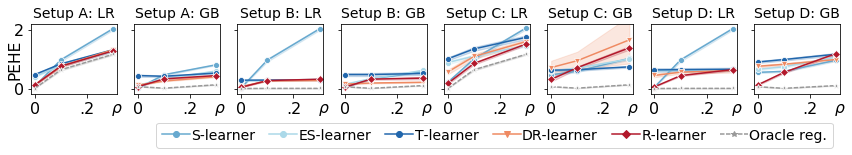

In [24]:
plt.figure(figsize=(14.5, 1.3))


crit_names = None  # factual
subset_n = 1000.0
subset_names = ["s", "s_ext", "t", "dr", "r", "oracle"]
xi = 0
prop = "prog"
xi_2 = 3
subset_cols = "missp_out"
subset_scl = 1
subset_inter_t = 0
subset_trans = 0
subset_rel_prop = 0.5
subset_splin = 0.3

pehe = True
rel = False
prefix = "rel_" if rel else ""
res_type = prefix + "rmse_factual" if not pehe else prefix + "rmse_cate"
res_type_methods = prefix + "test_factual" if not pehe else prefix + "test_pehe"

res_mean_lr, res_se_lr = agg_data(res_sel_lr, baseline_model="t-lr", drop_outliers=False)
res_mean_gb, res_se_gb = agg_data(res_sel_gbcv, baseline_model="t-xgb_cv", drop_outliers=False)

ylim = [-0.2, 2.2]
plt.subplot(181)
plot_frame = make_plot_frame(
    res_mean_lr,
    res_se_lr,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
    abbr=False,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup A: LR",
    ylab="PEHE",
    plot_sd=True,
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    colors=colors_by_learner(),
    ylim=ylim,
)

plt.subplot(182)
plot_frame = make_plot_frame(
    res_mean_gb,
    res_se_gb,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup A: GB",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    ylim=ylim,
)

plt.subplot(183)
plot_frame = make_plot_frame(
    res_mean_lr,
    res_se_lr,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup B: LR",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    ylim=ylim,
)

plt.subplot(184)
plot_frame = make_plot_frame(
    res_mean_gb,
    res_se_gb,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup B: GB",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    ylim=ylim,
)
plt.subplot(185)
plot_frame = make_plot_frame(
    res_mean_lr,
    res_se_lr,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup C: LR",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    ylim=ylim,
)


plt.subplot(186)
plot_frame = make_plot_frame(
    res_mean_gb,
    res_se_gb,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup C: GB",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    ylim=ylim,
)

plt.subplot(187)
plot_frame = make_plot_frame(
    res_mean_lr,
    res_se_lr,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    title=r"Setup D: LR",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    title_size=14,
    xlab=r"$\rho$",
    decimals=0,
    ylim=ylim,
)

plt.subplot(188)
plot_frame = make_plot_frame(
    res_mean_gb,
    res_se_gb,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=True,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=False,
    title=r"Setup D: GB",
    colors=colors_by_learner(),
    dashes=dashes_by_learner(),
    markers=markers_by_learner(),
    plot_sd=True,
    ylim=ylim,
    xlab=r"$\rho$",
    title_size=14,
    decimals=0,
    no_y=True,
)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    fontsize=14,
    bbox_to_anchor=(1, -0.3),
    ncol=len(ax.lines),
    handletextpad=0.1,
    columnspacing=1,
)
plt.savefig(RESULT_PLOT_DIR + f"main_learner.pdf", format="pdf", dpi=1200, bbox_inches="tight")

# Criterion fit

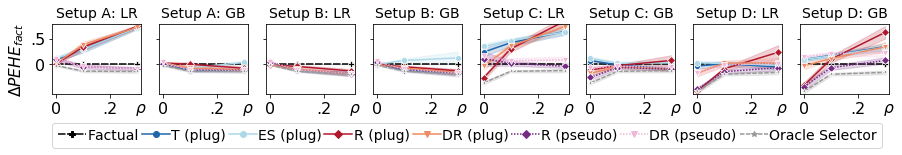

In [25]:
# compare by model
plt.figure(figsize=(15, 1.3))


subset_n = 1000.0
crit_names = ["factual", "t", "s_ext", "r_plug", "dr_plug", "r", "dr", "oracle"]
dashes = {
    "factual": "dashdot",
    "oracle": "dotted",
    "t": "solid",
    "s_ext": "solid",
    "r_plug": "solid",
    "r": "dashed",
    "dr": "dashed",
}
subset_names = None  # ['s', 's_ext', 't',  'oracle', 'dr', 'r']
xi = 0
prop = "prog"
xi_2 = 3
subset_cols = "missp_out"
subset_scl = 1
subset_inter_t = 0
subset_trans = 0
subset_rel_prop = 0.5
subset_splin = 0.3

pehe = True
rel = True
prefix = "rel_" if rel else ""
res_type = prefix + "rmse_factual" if not pehe else prefix + "rmse_cate"
res_type_methods = "test_factual" if not pehe else "test_pehe"

ylim = [-0.2, 0.8]
res_mean_all, res_se_all = agg_data(res_sel_all, drop_outliers=False)
decimals = "rem"
plt.subplot(181)
ylim1 = [-0.6, 0.8]
yticks1 = [0, 0.5]
xticks = [0, 0.2]
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["lr"],
    abbr=True,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim1,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    title=r"Setup A: LR",
    title_size=14,
    ylab=r"$\Delta PEHE_{fact}$",
    xlab=r"$\rho$",
    xticks=xticks,
    yticks=yticks1,
    colors=colors_by_crit(True),
)

plt.subplot(182)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    xlab=r"$\rho$",
    plot_sd=True,
    ylim=ylim1,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    title=r"Setup A: GB",
    title_size=14,
    xticks=xticks,
    yticks=yticks1,
    colors=colors_by_crit(True),
)

plt.subplot(183)
ylim2 = [-0.6, 0.8]
yticks2 = [0, 0.5]
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["lr"],
    abbr=True,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim2,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup B: LR",
    title_size=14,
    xticks=xticks,
    yticks=yticks2,
    colors=colors_by_crit(True),
)

plt.subplot(184)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim2,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup B: GB",
    title_size=14,
    xticks=xticks,
    yticks=yticks2,
    colors=colors_by_crit(True),
)


plt.subplot(185)
ylim3 = [-0.6, 0.8]
yticks3 = [0, 0.5]
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["lr"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim3,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup C: LR",
    title_size=14,
    xticks=xticks,
    yticks=yticks3,
    colors=colors_by_crit(True),
)

plt.subplot(186)

plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim3,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup C: GB",
    title_size=14,
    xticks=xticks,
    yticks=yticks3,
    colors=colors_by_crit(True),
)

plt.subplot(187)
ylim4 = [-0.6, 0.8]
yticks4 = [0, 0.5]
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["lr"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim4,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup D: LR",
    title_size=14,
    xticks=xticks,
    yticks=yticks4,
    colors=colors_by_crit(True),
)

plt.subplot(188)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    abbr=True,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=False,
    decimals=decimals,
    plot_sd=True,
    ylim=ylim4,
    dashes=dashes_by_crit(),
    markers=markers_by_crit(),
    xlab=r"$\rho$",
    title=r"Setup D: GB",
    title_size=14,
    xticks=xticks,
    yticks=yticks4,
    colors=colors_by_crit(True),
)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    fontsize=14,
    bbox_to_anchor=(1, -0.3),
    ncol=len(ax.lines),
    handletextpad=0.1,
    columnspacing=0.2,
)
plt.savefig(RESULT_PLOT_DIR + f"main_criteria.pdf", format="pdf", dpi=1200, bbox_inches="tight")

# Prediction performance

In [ ]:
res_pred = subset_results(res_full, subset_xi=[0, 3], subset_inter_t=0, subset_rel_prop=0.5)
res_sel_factual = make_new_selection(
    res_pred,
    learner_model_names=["lr", "xgb_cv"],
    include_oracle=True,
    crit_model_names=["lr", "xgb_cv"],
    learner_subset=["t", "s", "s_ext"],
    with_po=True,
)

In [27]:
dashes = {
    "Factual": (5, 1),
    "weighted Factual": (5, 1),
    "Oracle Selector": (3, 1),  # (0, (1, 10)),,,
    "R-LR (pseu.)": "",
    "R-GB (pseu.)": (1, 1),
}

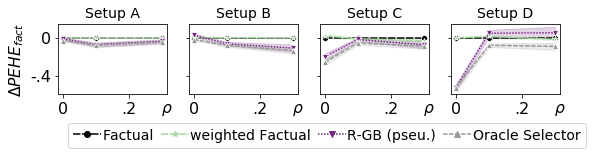

In [28]:
# comparing fit across different variations

plt.figure(figsize=(9, 1.3))

plt.subplot(131)

subset_n = 1000.0
crit_names = [
    "factual",
    "w_factual",
    "r",
    "oracle",
]
subset_names = ["s_ext", "t"]
xi = 0
prop = "prog"
xi_2 = 3
subset_cols = "missp_out"
subset_scl = 1
subset_inter_t = 0
subset_trans = 0
subset_rel_prop = 0.5
subset_splin = 0.3


pehe = True
rel = True
prefix = "rel_" if rel else ""
res_type = prefix + "rmse_factual" if not pehe else prefix + "rmse_cate"
res_type_methods = "test_factual" if not pehe else "test_pehe"


res_mean_all, res_se_all = agg_data(res_sel_factual)

ylim = [-0.6, 0.15]
yticks = [-0.4, 0]


plt.subplot(141)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["xgb_cv"],
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
    abbr=False,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    xlab=r"$\rho$",
    plot_sd=True,
    ylab=r"$\Delta PEHE_{fact}$",
    dashes=dashes,
    colors=colors_by_crit(False),
    title=r"Setup A",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(142)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["xgb_cv"],
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
    abbr=False,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup B",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(143)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    abbr=False,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup C",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(144)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    abbr=False,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=0.5,
    crit_model_names=["xgb_cv"],
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup D",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    fontsize=14,
    bbox_to_anchor=(1.3, -0.3),
    ncol=len(ax.lines),
    handletextpad=0.1,
    columnspacing=0.5,
)
plt.savefig(RESULT_PLOT_DIR + f"pred_pehe_main.pdf", format="pdf", dpi=1200, bbox_inches="tight")

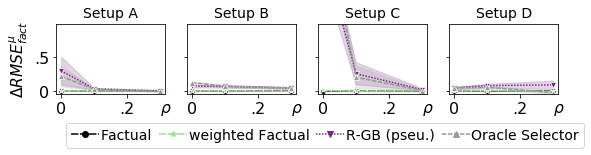

In [29]:
# comparing fit across different variations

plt.figure(figsize=(9, 1.3))

plt.subplot(131)

subset_n = 1000.0
crit_names = [
    "factual",
    "w_factual",
    "r",
    "oracle",
]
subset_names = ["s_ext", "t"]
xi = 0
prop = "prog"
xi_2 = 3
subset_cols = "missp_out"
subset_scl = 1
subset_inter_t = 0
subset_trans = 0
subset_rel_prop = 0.5
subset_splin = 0.3


pehe = True
rel = True
prefix = "rel_" if rel else ""
res_type = "rel_rmse_po"
res_type_methods = "test_factual" if not pehe else "test_pehe"


res_mean_all, res_se_all = agg_data(res_sel_factual)
ylim = [-0.05, 1.0]
yticks = [0, 0.5]


plt.subplot(141)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=0,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["xgb_cv"],
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
    abbr=False,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    xlab=r"$\rho$",
    plot_sd=True,
    ylab=r"$\Delta RMSE^\mu_{fact}$",
    dashes=dashes,
    colors=colors_by_crit(False),
    title=r"Setup A",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(142)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    crit_model_names=["xgb_cv"],
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
    abbr=False,
)

plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup B",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(143)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=subset_trans,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    abbr=False,
    subset_inter_t=subset_inter_t,
    subset_rel_prop=subset_rel_prop,
    crit_model_names=["xgb_cv"],
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup C",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


plt.subplot(144)
plot_frame = make_plot_frame(
    res_mean_all,
    res_se_all,
    subset_xi=xi_2,
    subset_prop=prop,
    plot_methods=False,
    subset_trans=1,
    dim_name="sp_1",
    subset_n=subset_n,
    crit_names=crit_names,
    abbr=False,
    subset_names=subset_names,
    subset_cols=subset_cols,
    subset_scl=subset_scl,
    subset_inter_t=0,
    subset_rel_prop=0.5,
    crit_model_names=["xgb_cv"],
    subset_splin=subset_splin,
    res_type=res_type,
    res_type_methods=res_type_methods,
)


plot_grouped_line_with_errorbars_2(
    plot_frame,
    input_feature="sp_1",
    outcome_feature="metric",
    no_legend=True,
    plot_sd=True,
    dashes=dashes,
    colors=colors_by_crit(False),
    xlab=r"$\rho$",
    title=r"Setup D",
    title_size=14,
    ylim=ylim,
    yticks=yticks,
)


ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    fontsize=14,
    bbox_to_anchor=(1.3, -0.3),
    ncol=len(ax.lines),
    handletextpad=0.1,
    columnspacing=0.5,
)
plt.savefig(RESULT_PLOT_DIR + f"pred_po_main.pdf", format="pdf", dpi=1200, bbox_inches="tight")

# Congeniality results

In [30]:
analyze_congeniality(res_sel_all)

,crit_name,sel_strat_t,sel_strat_dr,sel_strat_s,sel_strat_s_ext,sel_strat_r,sel_meth_lr,sel_meth_xgb_cv,sel_eq_strat_oracle,sel_eq_strat_factual,...,sel_eq_meth_oracle,sel_eq_meth_factual,sel_eq_meth_self,rel_sel_strat_t,rel_sel_strat_dr,rel_sel_strat_s,rel_sel_strat_s_ext,rel_sel_strat_r,rel_sel_meth_lr,rel_sel_meth_xgb_cv
0,oracle,0.056944,0.423611,0.229167,0.036111,0.254167,0.359722,0.640278,1.000000,0.169444,...,1.000000,0.169444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,factual,0.220833,0.000000,0.501389,0.277778,0.000000,0.138889,0.861111,0.169444,1.000000,...,0.169444,1.000000,0.000000,0.188889,0.000000,0.391667,0.250000,0.000000,0.119444,0.711111
0,t-lr,0.219444,0.258333,0.102778,0.312500,0.106944,0.709722,0.290278,0.173611,0.112500,...,0.173611,0.112500,0.709722,0.209722,0.156944,0.059722,0.304167,0.095833,0.676389,0.150000
0,t-xgb_cv,0.223611,0.458333,0.130556,0.108333,0.079167,0.090278,0.909722,0.352778,0.181944,...,0.352778,0.181944,0.909722,0.179167,0.220833,0.080556,0.097222,0.069444,0.076389,0.570833
0,dr-lr,0.208333,0.370833,0.112500,0.179167,0.129167,0.355556,0.644444,0.326389,0.162500,...,0.326389,0.162500,0.355556,0.179167,0.154167,0.068056,0.163889,0.108333,0.287500,0.386111
0,dr-xgb_cv,0.172222,0.451389,0.129167,0.120833,0.126389,0.143056,0.856944,0.361111,0.179167,...,0.361111,0.179167,0.856944,0.130556,0.216667,0.084722,0.109722,0.097222,0.108333,0.530556
0,s-lr,0.000000,0.013889,0.888889,0.002778,0.094444,0.854167,0.145833,0.168056,0.062500,...,0.168056,0.062500,0.854167,0.000000,0.013889,0.766667,0.001389,0.050000,0.758333,0.073611
0,s-xgb_cv,0.018056,0.098611,0.723611,0.019444,0.140278,0.262500,0.737500,0.173611,0.229167,...,0.173611,0.229167,0.737500,0.018056,0.081944,0.583333,0.018056,0.125000,0.227778,0.598611
0,s_ext-lr,0.077778,0.213889,0.086111,0.516667,0.105556,0.730556,0.269444,0.175000,0.090278,...,0.175000,0.090278,0.730556,0.075000,0.111111,0.041667,0.504167,0.093056,0.695833,0.129167
0,s_ext-xgb_cv,0.108333,0.237500,0.219444,0.283333,0.151389,0.075000,0.925000,0.211111,0.173611,...,0.211111,0.173611,0.925000,0.093056,0.145833,0.136111,0.272222,0.141667,0.061111,0.727778


In [31]:
PRETTY_LEARNERS_SHORT = {
    "r": "R",
    "dr": "DR",
    "s": "S",
    "s_ext": "ES",
    "t": "T",
    "r-lr": "R (LR)",
    "dr-lr": "DR (LR)",
    "s-lr": "S (LR)",
    "s_ext-lr": "ES (LR)",
    "t-lr": "T (LR)",
    "r-xgb_cv": "R (GB)",
    "dr-xgb_cv": "DR (GB)",
    "s-xgb_cv": "S (GB)",
    "s_ext-xgb_cv": "ES (GB)",
    "t-xgb_cv": "T (GB)",
    "oracle": "Oracle reg.",
    "oracle-lr": "Oracle reg. (LR)",
    "oracle-xgb_cv": "Oracle reg. (GB)",
}

PRETTY_LEARNERS_LONG = {
    "r": "R-learner",
    "dr": "DR-learner",
    "s": "S-learner",
    "s_ext": "ES-learner",
    "t": "T-learner",
    "r-lr": "R-learner (LR)",
    "dr-lr": "DR-learner (LR)",
    "s-lr": "S-learner (LR)",
    "s_ext-lr": "ES-learner (LR)",
    "t-lr": "T-learner (LR)",
    "r-xgb_cv": "R-learner (GB)",
    "dr-xgb_cv": "DR-learner (GB)",
    "s-xgb_cv": "S-learner (GB)",
    "s_ext-xgb_cv": "ES-learner (GB)",
    "t-xgb_cv": "T-learner (GB)",
    "oracle": "Oracle reg.",
    "oracle-lr": "Oracle reg. (LR)",
    "oracle-xgb_cv": "Oracle reg. (GB)",
}

PRETTY_CRITS_LONG = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": "R (pseudo, LR)",
    "dr-lr": "DR (pseudo, LR)",
    "s-lr": "S (plug, LR)",
    "s_ext-lr": "ES (plug, LR)",
    "t-lr": "T (plug, LR)",
    "r-xgb_cv": "R (pseudo, GB)",
    "dr-xgb_cv": "DR (pseudo, GB)",
    "s-xgb_cv": "S (plug, GB)",
    "s_ext-xgb_cv": "ES (plug, GB)",
    "r_plug-xgb_cv": "R (plug, GB)",
    "dr_plug-xgb_cv": "DR (plug, GB)",
    "t-xgb_cv": "T (plug, GB)",
    "r_plug": "R (plug)",
    "dr_plug": "DR (plug)",
    "r_plug-lr": "R (plug, LR)",
    "dr_plug-lr": "DR (plug, LR)",
    "factual": "Factual",
    "oracle": "Oracle Selector",
    "w_factual": "weight. Fact.",
}

PRETTY_CRITS_LONG_S = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": "R-LR (pseu.)",
    "dr-lr": "DR (pseudo, LR)",
    "s-lr": "S (plug, LR)",
    "s_ext-lr": "ES (plug, LR)",
    "t-lr": "T (plug, LR)",
    "r-xgb_cv": "R-GB (pseu.)",
    "dr-xgb_cv": "DR (pseudo, GB)",
    "s-xgb_cv": "S (plug, GB)",
    "s_ext-xgb_cv": "ES (plug, GB)",
    "r_plug-xgb_cv": "R (plug, GB)",
    "dr_plug-xgb_cv": "DR (plug, GB)",
    "t-xgb_cv": "T (plug, GB)",
    "r_plug": "R (plug)",
    "dr_plug": "DR (plug)",
    "r_plug-lr": "R (plug, LR)",
    "dr_plug-lr": "DR (plug, LR)",
    "factual": "Fact.",
    "oracle": "Oracle Selec.",
    "w_factual": "w. Fact.",
}
PRETTY_CRITS_SHORT = {
    "r": r"R" + "\n" + " $ \it{(pseudo)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{pseudo}, R}$',
    "dr": r"DR" + "\n" + " $ \it{ (pseudo)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{pseudo}, DR}$',
    "r_plug": r"R " + "\n" + " $ \it{(plug)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{plug}, R}$',
    "dr_plug": r"DR " + "\n" + " $ \it{(plug)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{plug}, DR}$',
    "s": r"S" + "\n" + "$ \it{(plug)}$",  # '\n' + '$\mathcal{E}^{\mathrm{plug}, S}$',
    "s_ext": r"ES" + "\n" + " $ \it{(plug)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{plug}, SE}$',
    "t": r"T" + "\n" + " $ \it{(plug)}$",  # + '\n' + '$\mathcal{E}^{\mathrm{plug}, T}$',
    "r-lr": "R (pseudo)",
    "dr-lr": "DR (pseudo)",
    "s-lr": "S (plug)",
    "s_ext-lr": "ES (plug)",
    "t-lr": "T (plug)",
    "r-xgb_cv": "R (pseudo)",
    "dr-xgb_cv": "DR (pseudo)",
    "s-xgb_cv": "S (plug)",
    "s_ext-xgb_cv": "ES (plug)",
    "r_plug-xgb_cv": "R (plug)",
    "dr_plug-xgb_cv": "DR (plug)",
    "r_plug-lr": "R (plug)",
    "dr_plug-lr": "DR (plug)",
    "factual": "Factual",
    "oracle": "Oracle Selector",
    "t-xgb_cv": "T (plug)",
    "w_factual": "weight. Fact.",
}
METH_COL = {"lr": "#f6e8c3", "xgb_cv": "#80cdc1"}

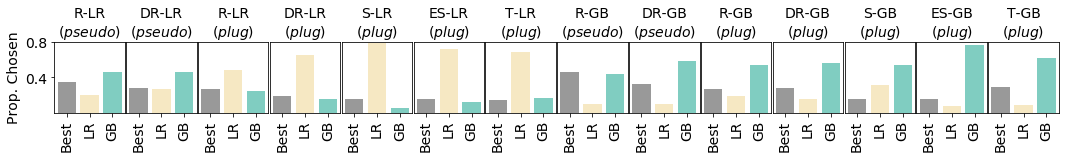

<Figure size 432x288 with 0 Axes>

In [32]:
# main and filtered

rel_res = True
strat_res = False
labsize = 14

subset_sp1 = None

res_sel = subset_results(res_sel_all, subset_sp1=subset_sp1, subset_n=1000)

cg_res = analyze_congeniality(res_sel)


col_type = (
    ("sel_strat_" if not rel_res else "rel_sel_strat_")
    if strat_res
    else ("sel_meth_" if not rel_res else "rel_sel_meth_")
)
strats_to_plot = ["lr", "xgb_cv"]
crit_names = [x + "-" + y for y in ["lr", "xgb_cv"] for x in ["r", "dr", "r_plug", "dr_plug", "s", "s_ext", "t"]]

n_crits = len(crit_names)
STRAT_NAMES = {"lr": "LR", "xgb_cv": "GB"}
PRETTY_CRITS_SHORTMETH = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": r"R-LR" + "\n" + "$\it{(pseudo)}$",
    "dr-lr": r"DR-LR" + "\n" + "$\it{(pseudo)}$",
    "s-lr": r"S-LR" + "\n" + "$\it{(plug)}$",
    "s_ext-lr": r"ES-LR" + "\n" + "$\it{(plug)}$",
    "t-lr": r"T-LR" + "\n" + "$\it{(plug)}$",
    "r_plug-lr": r"R-LR" + "\n" + "$\it{(plug)}$",
    "dr_plug-lr": r"DR-LR" + "\n" + "$\it{(plug)}$",
    "r-xgb_cv": r"R-GB" + "\n" + "$\it{(pseudo)}$",
    "dr-xgb_cv": r"DR-GB" + "\n" + "$\it{(pseudo)}$",
    "s-xgb_cv": r"S-GB" + "\n" + "$\it{(plug)}$",
    "s_ext-xgb_cv": r"ES-GB" + "\n" + "$\it{(plug)}$",
    "t-xgb_cv": r"T-GB" + "\n" + "$\it{(plug)}$",
    "r_plug-xgb_cv": r"R-GB" + "\n" + "$\it{(plug)}$",
    "dr_plug-xgb_cv": r"DR-GB" + "\n" + "$\it{(plug)}$",
}


plt.figure(figsize=(18, 1.3))
idx = 1
for crit in crit_names:
    plt.subplot(1, n_crits, idx)
    crit_name = crit
    if rel_res:
        plt.bar(
            "Best",
            cg_res.loc[
                cg_res["crit_name"] == crit_name, ("sel_eq_strat_oracle" if strat_res else "sel_eq_meth_oracle")
            ],
            color=COLORS_LEARNER["oracle"],
        )
    for strat in strats_to_plot:
        plt.bar(
            STRAT_NAMES[strat], cg_res.loc[cg_res["crit_name"] == crit_name, col_type + strat], color=METH_COL[strat]
        )
    plt.xticks(rotation=90, fontsize=labsize)
    plt.yticks([0.4, 0.8] if idx == 1 else [], fontsize=labsize)
    plt.title(PRETTY_CRITS_SHORTMETH[crit], fontsize=labsize)
    plt.ylim((0, 0.8))
    if idx == 1:
        plt.ylabel("Prop. Chosen", fontsize=labsize)
    idx += 1
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.savefig(RESULT_PLOT_DIR + f"cong_main_meth.pdf", format="pdf", dpi=1200, bbox_inches="tight")
plt.show()
plt.tight_layout()

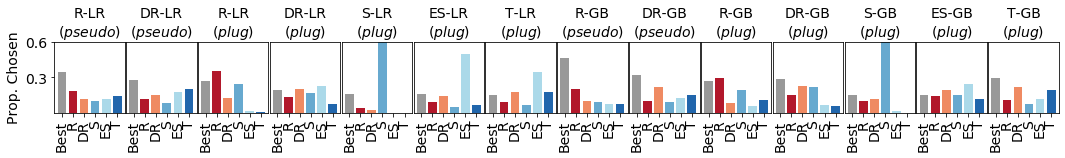

<Figure size 432x288 with 0 Axes>

In [33]:
# main and filtered

rel_res = True
strat_res = True
labsize = 14

subset_sp1 = None

res_sel = subset_results(res_sel_all, subset_sp1=subset_sp1, subset_n=1000)

cg_res = analyze_congeniality(res_sel)


col_type = (
    ("sel_strat_" if not rel_res else "rel_sel_strat_")
    if strat_res
    else ("sel_meth_" if not rel_res else "rel_sel_meth_")
)
strats_to_plot = ["r", "dr", "s", "s_ext", "t"]
crit_names = [x + "-" + y for y in ["lr", "xgb_cv"] for x in ["r", "dr", "r_plug", "dr_plug", "s", "s_ext", "t"]]

n_crits = len(crit_names)
STRAT_NAMES = {
    "r": "R",
    "dr": "DR",
    "s": "S",
    "s_ext": "ES",
    "t": "T",
}
PRETTY_CRITS_SHORTMETH = {
    "r": "R (pseudo)",
    "dr": "DR (pseudo)",
    "s": "S (plug-in)",
    "s_ext": "ES (plug-in)",
    "t": "T  (plug-in)",
    "r-lr": r"R-LR" + "\n" + "$\it{(pseudo)}$",
    "dr-lr": r"DR-LR" + "\n" + "$\it{(pseudo)}$",
    "s-lr": r"S-LR" + "\n" + "$\it{(plug)}$",
    "s_ext-lr": r"ES-LR" + "\n" + "$\it{(plug)}$",
    "t-lr": r"T-LR" + "\n" + "$\it{(plug)}$",
    "r_plug-lr": r"R-LR" + "\n" + "$\it{(plug)}$",
    "dr_plug-lr": r"DR-LR" + "\n" + "$\it{(plug)}$",
    "r-xgb_cv": r"R-GB" + "\n" + "$\it{(pseudo)}$",
    "dr-xgb_cv": r"DR-GB" + "\n" + "$\it{(pseudo)}$",
    "s-xgb_cv": r"S-GB" + "\n" + "$\it{(plug)}$",
    "s_ext-xgb_cv": r"ES-GB" + "\n" + "$\it{(plug)}$",
    "t-xgb_cv": r"T-GB" + "\n" + "$\it{(plug)}$",
    "r_plug-xgb_cv": r"R-GB" + "\n" + "$\it{(plug)}$",
    "dr_plug-xgb_cv": r"DR-GB" + "\n" + "$\it{(plug)}$",
}


plt.figure(figsize=(18, 1.3))
idx = 1
for crit in crit_names:
    plt.subplot(1, n_crits, idx)
    crit_name = crit
    if rel_res:
        plt.bar(
            "Best",
            cg_res.loc[
                cg_res["crit_name"] == crit_name, ("sel_eq_strat_oracle" if strat_res else "sel_eq_meth_oracle")
            ],
            color=COLORS_LEARNER["oracle"],
        )
    for strat in strats_to_plot:
        plt.bar(
            STRAT_NAMES[strat],
            cg_res.loc[cg_res["crit_name"] == crit_name, col_type + strat],
            color=COLORS_LEARNER[strat],
        )
    plt.xticks(rotation=90, fontsize=labsize)
    plt.yticks([0.3, 0.6] if idx == 1 else [], fontsize=labsize)
    plt.title(PRETTY_CRITS_SHORTMETH[crit], fontsize=labsize)
    plt.ylim((0, 0.6))
    if idx == 1:
        plt.ylabel("Prop. Chosen", fontsize=labsize)
    idx += 1
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.savefig(RESULT_PLOT_DIR + f"cong_main_strat.pdf", format="pdf", dpi=1200, bbox_inches="tight")
plt.show()
plt.tight_layout()